In [29]:
import train_cnn
import stacked_ae
import utils
import matplotlib.pyplot as plt 
import numpy as np
import imp
import cv2
imp.reload(train_cnn)
imp.reload(utils)
imp.reload(stacked_ae)
%matplotlib inline
import pandas as pd

# Test for CNN

## Trainset

`models_cnn = {model type : [X, X_fullsize, Y, contour_mask, y_pred, history, model]}`  
Training CNN --> it took 2min (simple), 5min (2 convs)

In [3]:
variants = ['simple', 'larger', 'deeper', 'maxpooling']
models_cnn = {k:train_cnn.run(model=k, history=True) for k in variants}
models_cnn['relu'] = train_cnn.run(model='simple', history=True, activation='relu')

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)
Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)
Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)
Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)
Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


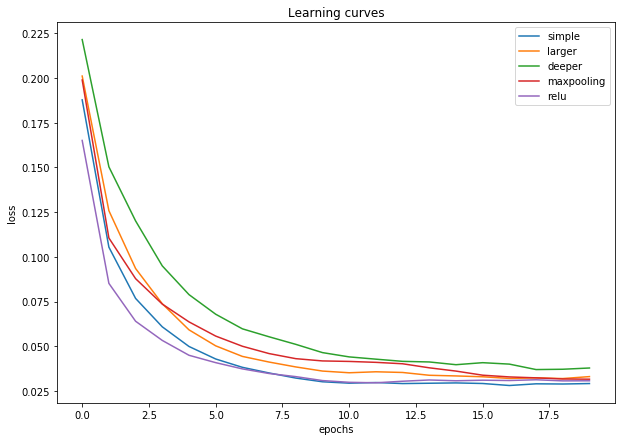

In [6]:
plt.figure(figsize=(10,7))
for k, v in models_cnn.items():
    it = range(len(v[5].history['loss']))
    plt.plot(it, v[5].history['loss'], label=k)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title("Learning curves")
plt.legend()

`models_stackedae = {model type : [X, Y, binarys, model]}`  
Training stacked AE --> it took 23s

In [7]:
models_stackedae = {k:stacked_ae.run(v[1], v[4], v[3]) for k,v in models_cnn.items()}

`metrics = {model type : [dice metric, conformity coefficient]}`  

In [9]:
metrics = {k:utils.stats_results(v[1], v[2]) for k,v in models_stackedae.items()}

In [10]:
for k, v in metrics.items():
    print('%s - DM :%.1f%%, CC :%.1f, Top 5 :' % (k, 100*v[0].mean(), v[1].mean()), 
         list(zip(sorted(map(lambda x:'%.2f' % x, v[0]), reverse=True)[:5], v[0].argsort()[::-1][:5])))

simple - DM :32.8%, CC :-12.8, Top 5 : [('0.86', 448), ('0.86', 297), ('0.82', 183), ('0.82', 174), ('0.78', 90)]
larger - DM :36.9%, CC :-17.0, Top 5 : [('0.83', 262), ('0.83', 327), ('0.83', 117), ('0.83', 484), ('0.82', 389)]
deeper - DM :40.4%, CC :-9.7, Top 5 : [('0.87', 43), ('0.87', 81), ('0.87', 206), ('0.87', 290), ('0.86', 315)]
maxpooling - DM :39.1%, CC :-14.7, Top 5 : [('0.95', 81), ('0.95', 290), ('0.95', 206), ('0.95', 43), ('0.90', 426)]
relu - DM :40.1%, CC :-17.5, Top 5 : [('0.89', 432), ('0.89', 42), ('0.89', 230), ('0.89', 163), ('0.89', 258)]


In [137]:
# Find the index that maximizes all models
dm = {k:v[0] for k,v in metrics.items()}
df = pd.DataFrame(dm)
df[df>0.6].dropna(how='any').sort_values('larger', ascending=False).head(10)

,deeper,larger,maxpooling,relu,simple
439,0.652424,0.821918,0.705010,0.647251,0.700455
428,0.652424,0.821918,0.705010,0.647251,0.700455
460,0.647059,0.805677,0.883983,0.644723,0.644578
441,0.647059,0.805677,0.883983,0.644723,0.644578
433,0.647059,0.805677,0.883983,0.644723,0.644578
432,0.647059,0.805677,0.883983,0.644723,0.644578
221,0.759494,0.798122,0.759102,0.842817,0.759713
223,0.759494,0.798122,0.759102,0.842817,0.759713
230,0.759494,0.798122,0.759102,0.842817,0.759713
235,0.759494,0.798122,0.759102,0.842817,0.759713


Text(0.5,1,'Ground Truth')

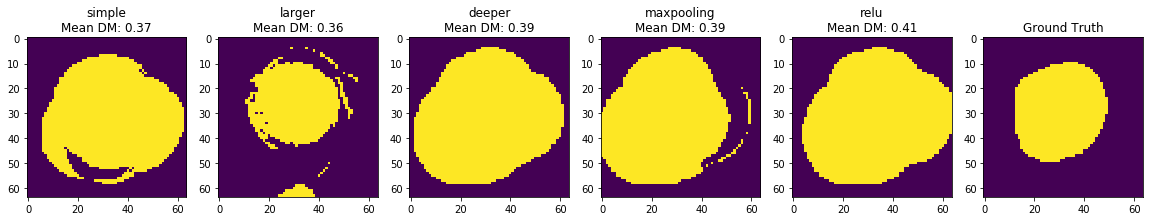

In [138]:
idx = 439
f, ax = plt.subplots(ncols=len(metrics)+1, figsize=(20,5))
for i, (model, v) in enumerate(models_stackedae.items()):
    ax[i].imshow(v[2][idx])
    ax[i].set_title('%s\nMean DM: %.2f' % (model, metrics[model][0].mean()))
ax[5].imshow(v[1][idx].reshape((64,64)))
ax[5].set_title('Ground Truth')

## Test set

`inference_cnn = {model type : [X_test, X_fullsize_test, Y_test, contour_mask_test, y_pred_test]}`  
Inference CNN --> it took 24s

In [16]:
inference_cnn = {k:train_cnn.inference(v[6]) for k,v in models_cnn.items()}

Dataset shape : (524, 64, 64, 1) (524, 1, 32, 32)
Dataset shape : (524, 64, 64, 1) (524, 1, 32, 32)
Dataset shape : (524, 64, 64, 1) (524, 1, 32, 32)
Dataset shape : (524, 64, 64, 1) (524, 1, 32, 32)
Dataset shape : (524, 64, 64, 1) (524, 1, 32, 32)


`inference_sae = {model type : [X_, Y_, binarys_test]}`  
Inference Stacked AE --> it took 0.4s

In [17]:
inference_sae = {k:stacked_ae.inference(v[1], v[4], v[3], models_stackedae[k][3]) for k,v in inference_cnn.items()}

`metrics_test = {model type : [dice metric, conformity coefficient]}`  

In [18]:
metrics_test = {k:utils.stats_results(v[1], v[2]) for k,v in inference_sae.items()}

In [19]:
print('model - DM: Test (Train), CC: Test (Train)')
for (k, v), (k1,v1) in zip(metrics_test.items(),metrics.items()):
    print('%s - DM: %.1f%% (%.1f%%), CC: %.1f (%.1f)' % (k, 100*v[0].mean(), 100*v1[0].mean(), 
                                                     v[1].mean(), v1[1].mean()))

model - DM: Test (Train), CC: Test (Train)
simple - DM: 33.6% (32.8%), CC: -9.8 (-12.8)
larger - DM: 27.5% (36.9%), CC: -44.6 (-17.0)
deeper - DM: 35.3% (40.4%), CC: -11.5 (-9.7)
maxpooling - DM: 31.2% (39.1%), CC: -32.2 (-14.7)
relu - DM: 27.8% (40.1%), CC: -24.4 (-17.5)


In [22]:
# Find the index that maximizes all models
dm = {k:v[0] for k,v in metrics_test.items()}
cc = {k:v[1] for k,v in metrics_test.items()}
df = pd.DataFrame(dm)
df[df>0.6].dropna(how='any').sort_values('simple', ascending=False).head(10)

,deeper,larger,maxpooling,relu,simple
73,0.606589,0.699397,0.710306,0.696623,0.682258
86,0.606589,0.699397,0.710306,0.696623,0.682258
26,0.632131,0.631304,0.633247,0.664557,0.618981
154,0.632131,0.631304,0.633247,0.664557,0.618981
284,0.632131,0.631304,0.633247,0.664557,0.618981
313,0.632131,0.631304,0.633247,0.664557,0.618981
72,0.634911,0.646386,0.644930,0.628872,0.617143


Text(0.5,1,'Ground Truth')

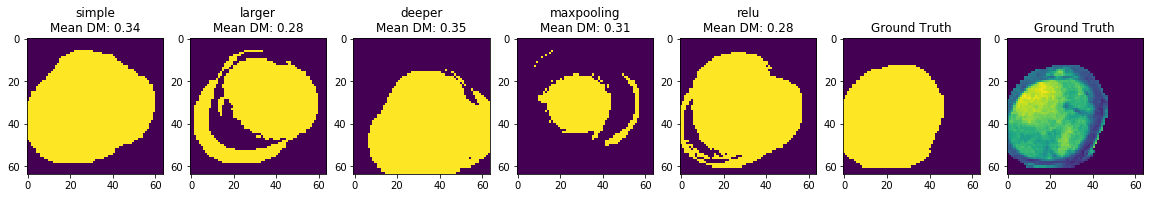

In [31]:
idx = 84
f, ax = plt.subplots(ncols=len(metrics_test)+2, figsize=(20,5))
for i, (model, v) in enumerate(inference_sae.items()):
    ax[i].imshow(v[2][idx])
    ax[i].set_title('%s\nMean DM: %.2f' % (model, metrics_test[model][0].mean()))
#     cv2.imwrite('./Rapport/images/results_%s_img%s.png' % (model,idx), v[2][idx]*255)
ax[5].imshow(v[1][idx].reshape((64,64)))
ax[5].set_title('Ground Truth')

ax[6].imshow(v[1][idx].reshape((64,64))*v[0][idx].reshape((64,64)))
ax[6].set_title('Ground Truth')

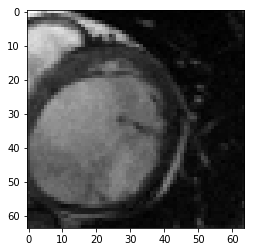

In [65]:
i = v[1][idx].reshape((64,64))*v[0][idx].reshape((64,64))
plt.imshow(v[0][idx].reshape((64,64)), cmap='gray')

## Find contours

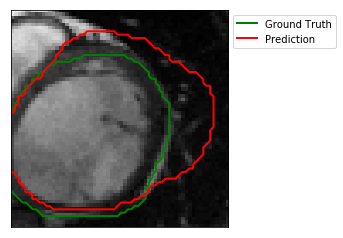

In [77]:
from skimage import measure
# Find contours at a constant value of 0.8
contours_truth = measure.find_contours(v[1][idx].reshape((64,64)), 0.8)
contours_simple = measure.find_contours(inference_sae['simple'][2][idx], 0.8)

fig, ax = plt.subplots()
ax.imshow(v[0][idx].reshape((64,64)), cmap='gray')

for n, contour in enumerate(contours_truth):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='green', label='Ground Truth')
for n, contour in enumerate(contours_simple):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red', label='Prediction')
    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('./Rapport/images/image_with_contour_truth_pred.png')

# Tests for Stacked AE

## Train set

In [163]:
try:
    _, X_fullsize, _, contour_mask, y_pred, h, m = models_cnn['simple']
except:
    _, X_fullsize, _, contour_mask, y_pred, h, m = train_cnn.run(model='simple', history=True)

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


`models_sae_init = {init type : [X, Y, binarys, model, history]}`   

In [164]:
inits = ['zero', 'random_uniform', 'random_normal']
models_sae_init = {k:stacked_ae.run(X_fullsize, y_pred, contour_mask, init_3=k, history=True) for k in inits}

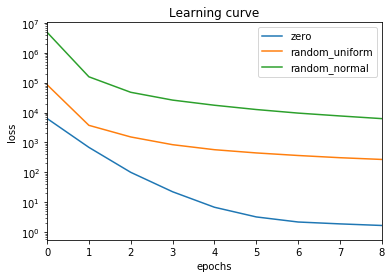

In [148]:
for k, v in models_sae_init.items():
    it = range(len(v[4]))
    plt.plot(it, v[4], label=k)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title("Learning curve")
plt.legend()
plt.xlim([0,8])
plt.yscale("log", nonposy='clip')

`models_sae_loss = {loss type : [X, Y, binarys, model, history]}`   

In [165]:
loss = ["customized_loss", "MSE", "kullback_leibler_divergence"]
models_sae_loss = {'%s + MSE' % l :stacked_ae.run(X_fullsize, y_pred, contour_mask, history=True, 
                            loss1=l, loss2=l, loss3="MSE") for l in loss}

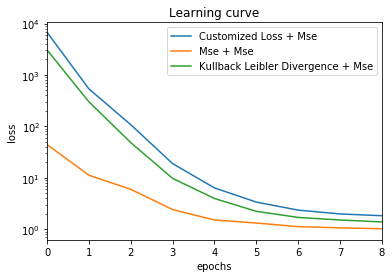

In [129]:
for k, v in models_sae_loss.items():
    it = range(len(v[4]))
    plt.plot(it, v[4], label=k.replace('_', ' ').title())
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title("Learning curve")
plt.legend()
plt.xlim([0,8])
plt.yscale("log", nonposy='clip')
plt.savefig('./Rapport/images/learning_curve_loss_sae.png')

`metrics = {loss type : [dice metric, conformity coefficient]}`  

In [166]:
metrics_sae_loss = {k:utils.stats_results(v[1], v[2]) for k, v in models_sae_loss.items()}

In [126]:
for k, v in metrics_sae_loss.items():
    print('%s - DM :%.1f%%, CC :%.1f' % (k, 100*v[0].mean(), v[1].mean()))

customized_loss + MSE - DM :42.3%, CC :-11.2
MSE + MSE - DM :42.1%, CC :-9.6
kullback_leibler_divergence + MSE - DM :38.9%, CC :-10.1


Text(0.5,1,'Ground Truth')

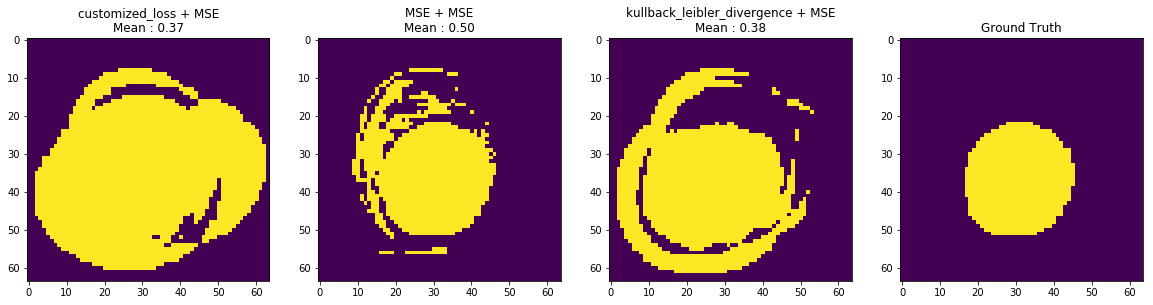

In [242]:
idx = 47
f, ax = plt.subplots(ncols=len(metrics_sae_loss)+1, figsize=(20,5))
for i, (model, v) in enumerate(models_sae_loss.items()):
    ax[i].imshow(v[2][idx])
    ax[i].set_title('%s\nMean : %.2f' % (model, metrics_sae_loss[model][0].mean()))
ax[3].imshow(v[1][idx].reshape((64,64)))
ax[3].set_title('Ground Truth')

## Test set

In [167]:
X_test, X_fullsize_test, Y_test, contour_mask_test, y_pred = train_cnn.inference(models_cnn['simple'][6])

Dataset shape : (524, 64, 64, 1) (524, 1, 32, 32)


In [168]:
inference_sae_loss = {k:stacked_ae.inference(X_fullsize_test, y_pred, contour_mask_test, v[3]) 
                          for k,v in models_sae_loss.items()}

In [169]:
metrics_sae_loss_inf = {k:utils.stats_results(v[1], v[2]) for k, v in inference_sae_loss.items()}

In [170]:
print('model - DM: Test (Train), CC: Test (Train)')
for (k, v), (k1,v1) in zip(metrics_sae_loss_inf.items(),metrics_sae_loss.items()):
    print('%s - DM: %.1f%% (%.1f%%), CC: %.1f (%.1f)' % (k, 100*v[0].mean(), 100*v1[0].mean(), 
                                                     v[1].mean(), v1[1].mean()))

model - DM: Test (Train), CC: Test (Train)
customized_loss + MSE - DM: 31.8% (41.8%), CC: -13.7 (-10.9)
MSE + MSE - DM: 40.0% (37.3%), CC: -11.0 (-14.4)
kullback_leibler_divergence + MSE - DM: 23.4% (39.7%), CC: -39.9 (-8.1)


In [188]:
# Find the index that maximizes all models
dm = {k:v[0] for k,v in metrics_sae_loss.items()}
cc = {k:v[1] for k,v in metrics_sae_loss.items()}
df = pd.DataFrame(dm)
df[df['MSE + MSE'] - df['customized_loss + MSE'] > 0.1].sort_values('MSE + MSE', ascending=False)

,MSE + MSE,customized_loss + MSE,kullback_leibler_divergence + MSE
493,0.699399,0.461793,0.696970
133,0.699399,0.461793,0.696970
474,0.699399,0.461793,0.696970
141,0.699399,0.461793,0.696970
280,0.632911,0.420021,0.682594
267,0.628308,0.527366,0.417308
358,0.628308,0.527366,0.417308
452,0.611787,0.233085,0.691385
217,0.611787,0.233085,0.691385
289,0.594107,0.023622,0.000000


Text(0.5,1,'Ground Truth')

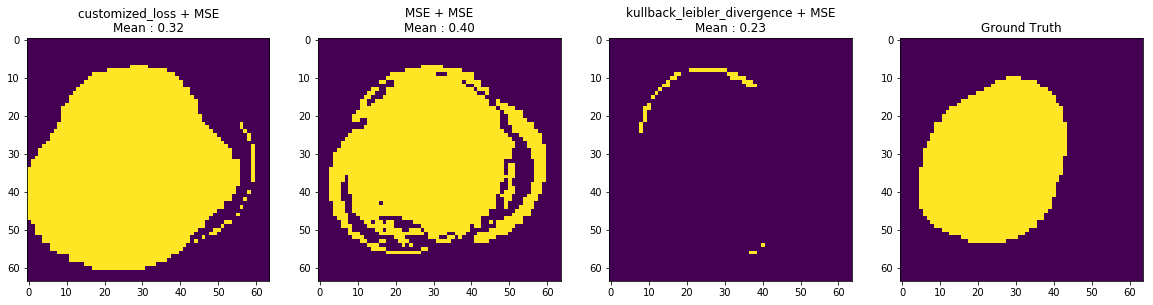

In [193]:
idx = 474
f, ax = plt.subplots(ncols=len(metrics_sae_loss_inf)+1, figsize=(20,5))
for i, (model, v) in enumerate(inference_sae_loss.items()):
    ax[i].imshow(v[2][idx])
    ax[i].set_title('%s\nMean : %.2f' % (model, metrics_sae_loss_inf[model][0].mean()))
ax[3].imshow(v[1][idx].reshape((64,64)))
ax[3].set_title('Ground Truth')

In [194]:
inference_sae_loss.keys()

dict_keys(['customized_loss + MSE', 'MSE + MSE', 'kullback_leibler_divergence + MSE'])

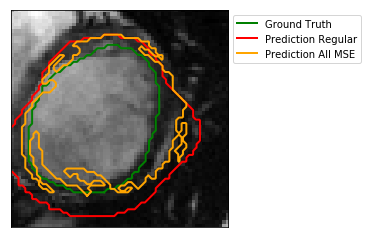

In [205]:
from skimage import measure
# Find contours at a constant value of 0.8
contours_truth = measure.find_contours(v[1][idx].reshape((64,64)), 0.8)
contours_simple = measure.find_contours(inference_sae_loss['customized_loss + MSE'][2][idx], 0.8)
contours_mse = measure.find_contours(inference_sae_loss['MSE + MSE'][2][idx], 0.8)

fig, ax = plt.subplots()
ax.imshow(v[0][idx].reshape((64,64)), cmap='gray')

for n, contour in enumerate(contours_truth):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='green', label='Ground Truth')
for n, contour in enumerate(contours_simple[:1]):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red', label='Prediction Regular')
for n, contour in enumerate(contours_mse[:1]):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='orange', label='Prediction All MSE')
    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.legend(bbox_to_anchor=(1,1))
plt.savefig('./Rapport/images/image_with_contour_truth_pred_SAE.png')